# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with simply "mnist" and everything should work fine.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from timeit import default_timer as timer
from math import log, e

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)


# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

In [3]:
#initialize labelled data frame for easy access by label
data_labelled = pd.DataFrame(mini_train_data, index = mini_train_labels)
digits = range(10)

In [4]:
#general method to reshape and plot an image on grayscale with no tick labels
def show_image(ax, image):
    ax.imshow(np.array(image).reshape(28,28), cmap='gray')
    ax.set_xticklabels([])
    ax.set_yticklabels([])

In [5]:
def P1(num_examples=10):
    fig_size = 10
    fig = plt.figure(figsize=(fig_size,fig_size))
    i=0
    for digit in digits:
        #get first num_examples matching the given label
        images = data_labelled.loc[str(digit)].head(num_examples).values.tolist()
        j=1
        #plot images for each digit
        for image in images:
            ax = fig.add_subplot(10, num_examples, i*num_examples + j)
            show_image(ax, image)
            j += 1
        i += 1
    plt.show()

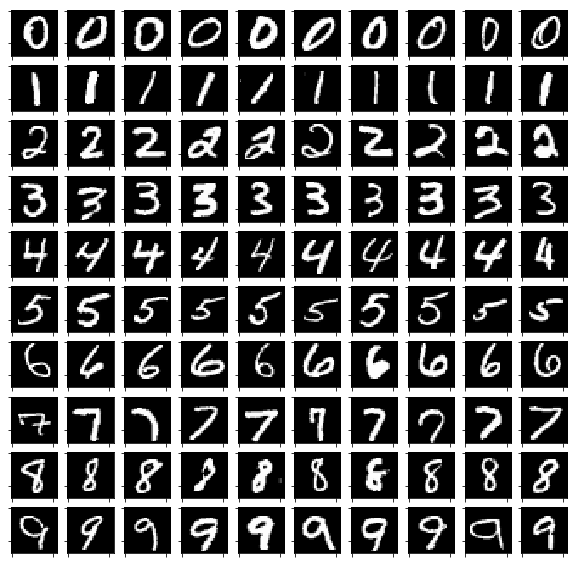

In [6]:
P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [7]:
def P2(k_values):
    for k in k_values:
        #init and fit classifier
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(mini_train_data, mini_train_labels)
        if k == 1:
            #predict and report on dev data
            dev_pred_labels = neigh.predict(dev_data)
            print(classification_report(dev_labels, dev_pred_labels))
            print(accuracy_score(dev_labels, dev_pred_labels))

In [8]:
k_values = [1, 3, 5, 7, 9]
P2(k_values)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

   micro avg       0.88      0.88      0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

0.884


ANSWER: Using the classification report above it looks like 8 is the most difficult digit to classify. While it's precision is never the smallest across any of the k values, it is always low, and it's recall is always the lowest. We also notice that the combination of these two features the f1-score is always the lowest for the digit 8. The very low Recall means that we are seeing a large number of false negatives which suggests that we are often mistaking 8's for other digits.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [9]:
default_k = 1
neigh_train = KNeighborsClassifier(n_neighbors=default_k)

def P3(train_sizes):
    timings = []
    accuracies = []
    for size in train_sizes:
        train_data_temp, train_labels_temp = train_data[:size], train_labels[:size]
        neigh_train.fit(train_data_temp, train_labels_temp)
        start = timer()
        dev_train_pred_labels = neigh_train.predict(dev_data)
        end = timer()
        predict_time = end - start
        timings.append(predict_time)
        accuracies.append(accuracy_score(dev_labels,dev_train_pred_labels))
    sizes_and_timings = dict(zip(train_sizes, timings))
    print('Time to predict dev set (in seconds) by training set size:')
    #print items as tuples separated by new lines
    print(*sizes_and_timings.items(), sep='\n')
    return accuracies, timings

In [10]:
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies, timings = P3(train_sizes)

sizes_and_accuracies = dict(zip(train_sizes, accuracies))
print('\nAccuracies by training set size:')
print(*sizes_and_accuracies.items(), sep='\n')

Time to predict dev set (in seconds) by training set size:
(100, 0.1441281000000032)
(200, 0.2767417000000023)
(400, 0.5909908000000001)
(800, 1.1450803999999977)
(1600, 2.649685599999998)
(3200, 5.980094399999999)
(6400, 11.0889406)
(12800, 22.186328599999996)
(25000, 37.634589300000016)

Accuracies by training set size:
(100, 0.702)
(200, 0.791)
(400, 0.811)
(800, 0.866)
(1600, 0.905)
(3200, 0.927)
(6400, 0.939)
(12800, 0.952)
(25000, 0.962)


[100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
[0.702, 0.791, 0.811, 0.866, 0.905, 0.927, 0.939, 0.952, 0.962]


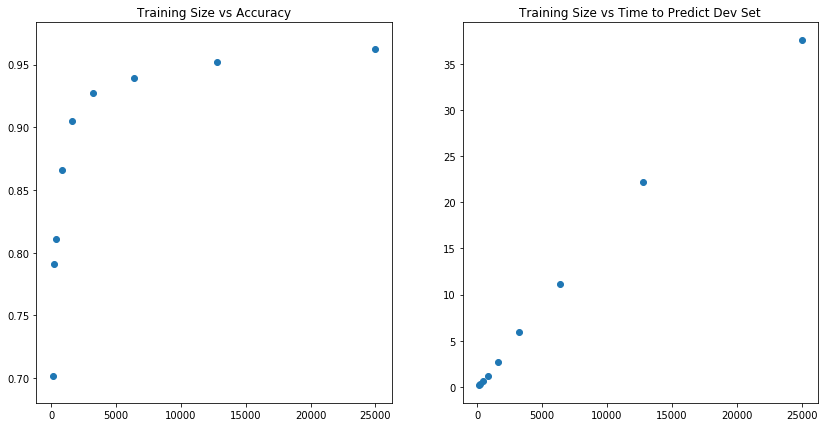

In [11]:
#some ad hoc analysis to look at shape of acc/training size curves
print(train_sizes)
print(accuracies)
fig_size = 7
ncols = 2
nrows = 1
fig = plt.figure(figsize=(ncols*fig_size,nrows*fig_size))

ax = fig.add_subplot(nrows,ncols,1)
ax.scatter(train_sizes, accuracies)
ax.set_title('Training Size vs Accuracy')

ax2 = fig.add_subplot(nrows,ncols,2)
ax2.scatter(train_sizes, timings)
ax2.set_title('Training Size vs Time to Predict Dev Set')

plt.show()

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [12]:
#define P4 method with function-valued parameter to make the next part (playing with the transformation) easy
def P4(train_sizes, n_test, tr = lambda x: x):
    reg = LinearRegression()
    #fit LR with each run from above as a data point with a single feature
    reg.fit([[tr(s)] for s in train_sizes], accuracies)
    pred = reg.predict([[tr(n_test)]])
    print('Linear Regression Model predicts an accuracy of ' + '{:5.3f}'.format(pred[0]) + ' for the sample size of ' + str(n_test))

n_test = 60000
P4(train_sizes, n_test)

Linear Regression Model predicts an accuracy of 1.245 for the sample size of 60000


ANSWER: Linear Regression is not the right choice because, as seen from the plot above, the data does not follow a linear pattern. It is closer to a logarithmic curve, so applying a logarithmic transformation may help the fit. However, as seen below even a logarithmic transformation predicts an accuracy of over 100% with a sample size of 60000. This is because the log function is not bounded whereas we know our accuracy variable is. Still the log transformation is the easiest choice to produce a better fit within an acceptable range of sample sizes (100-60000).

In [13]:
P4(train_sizes, n_test, tr= log) #pass in log as the transformation

Linear Regression Model predicts an accuracy of 1.034 for the sample size of 60000


# Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

[[105   0   0   0   0   0   0   0   1   0]
 [  0 117   0   0   0   0   0   0   1   0]
 [  1   0 101   1   0   0   0   3   0   0]
 [  0   1   0  87   0   3   0   2   4   0]
 [  0   0   0   0  87   0   0   1   0   4]
 [  1   0   0   1   0  82   3   0   0   1]
 [  0   2   0   0   0   1  99   0   0   0]
 [  0   0   1   0   1   0   0 100   0   0]
 [  0   1   1   3   1   1   2   0  83   2]
 [  0   1   0   0   3   0   0   0   0  91]]


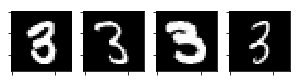

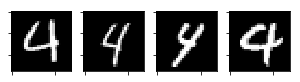

In [14]:
def P5():
    default_k = 1
    default_size = 12800
    neigh_train = KNeighborsClassifier(n_neighbors=default_k)
    train_data_temp, train_labels_temp = train_data[:default_size], train_labels[:default_size]
    neigh_train.fit(train_data_temp, train_labels_temp)
    dev_train_pred_labels = neigh_train.predict(dev_data)
    # use confusion matrix to find mistakes
    print(confusion_matrix(dev_labels, dev_train_pred_labels))

    # init a df with columns that are easier to work with for filtering
    dev_df = pd.DataFrame(list(zip(dev_data, dev_labels, dev_train_pred_labels)), columns=['data','lbl','lbl_p'])
    
    # filter to the issues we found above, i.e. 3 and 4 being mis-classified as 8 and 9 respectively
    threes_fn = dev_df[(dev_df['lbl'] == '3') & (dev_df['lbl_p'] == '8')]
    fours_fn = dev_df[(dev_df['lbl'] == '4') & (dev_df['lbl_p'] == '9')]
    arrs_fn = [threes_fn, fours_fn]

    #plot out examples of porblem images
    fig_size = 5
    i=0
    for arr_fn in arrs_fn:  
        fig = plt.figure(figsize=(fig_size,fig_size))
        j=1
        for image in arr_fn['data']:
            ax = fig.add_subplot(len(arrs_fn), len(arr_fn), i*len(arr_fn) + j)
            show_image(ax, image)
            j += 1
        i += 1
    plt.show()

P5()

The most mistakes in this model happened when mistaking 3's for 8's and 4's for 9's. This makes sense as these numbers do have similar patterns with only 1 or 2 spaces between lines making the difference. Some examples of mistakes are shows above.

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [15]:
# simple (and slow) method to blur an image based on the surrounding pixels
def blur_image(image):
    reshaped = image.reshape(28,28)
    blurred = []
    for i in range(len(reshaped)):
        for j in range(len(reshaped[i])):
            # find the range we are going to use for the averaging
            i_min = 0 if ((i - 1) < 0) else (i - 1)
            i_max = i if ((i + 1) > (len(reshaped) - 1)) else (i + 1)
            j_min = 0 if ((j - 1) < 0) else (j - 1)
            j_max = j if ((j + 1) > (len(reshaped[i]) - 1)) else (j + 1)
            
            # compute average for this pixel and append to blurred image array
            tot = 0.0
            cnt = ((i_max + 1) - i_min) * ((j_max + 1) - j_min)
            for i_tmp in range(i_min, i_max + 1):
                for j_tmp in range(j_min, j_max + 1):
                    tot += reshaped[i_tmp][j_tmp]
            blurred.append(tot / cnt)
    return blurred

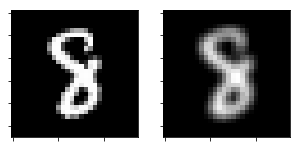

In [16]:
# some ad hoc testing

original = dev_data[0]
blurred = blur_image(dev_data[0])
        
fig_size = 5
fig = plt.figure(figsize=(fig_size,fig_size))
ax1 = fig.add_subplot(1, 2, 1)
show_image(ax1, original)
ax2 = fig.add_subplot(1, 2, 2)
show_image(ax2, blurred)

plt.show()

In [17]:
# use method from above to blur and test with various data sets
def P6():
    default_k = 1
    default_size = 1000
    neigh_train = KNeighborsClassifier(n_neighbors=default_k)
    train_data_temp, train_labels_temp = train_data[:default_size], train_labels[:default_size]
    train_data_blurred = [blur_image(data) for data in train_data_temp]
    dev_data_blurred = [blur_image(data) for data in dev_data]
    
    print('Baseline, No Blur:')
    neigh_train.fit(train_data_temp, train_labels_temp)
    pred_labels_base = neigh_train.predict(dev_data)
    print(classification_report(dev_labels, pred_labels_base))
    
    print('With Blurred Training Data:')
    neigh_train.fit(train_data_blurred, train_labels_temp)
    pred_labels_train_blur = neigh_train.predict(dev_data)
    print(classification_report(dev_labels, pred_labels_train_blur))
    
    print('With Blurred Dev Data:')
    neigh_train.fit(train_data_temp, train_labels_temp)
    pred_labels_dev_blur = neigh_train.predict(dev_data_blurred)
    print(classification_report(dev_labels, pred_labels_dev_blur))
    
    print('With Blurred Training and Dev Data:')
    neigh_train.fit(train_data_blurred, train_labels_temp)
    pred_labels_train_dev_blur = neigh_train.predict(dev_data_blurred)
    print(classification_report(dev_labels, pred_labels_train_dev_blur))

P6()

Baseline, No Blur:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

   micro avg       0.88      0.88      0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

With Blurred Training Data:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       106
           1       0.93      0.97      0.95       118
           2       0.93      0.

ANSWER: It is interesting to notice above that the best results came from blurring the training data but not the dev data. This seems to make sense because it allows you to use the blurring technique to make the trained model more susceptible to variation, but still allows you to use the full features of the data when actually classifying a dev image.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [18]:
# map an image to black, gray, white categories
def tri_map(data):
    mapped = []
    for d in data:
        mapped.append([0 if val == 0 else 2 if val == 1 else 1 for val in d])
    return mapped

# map an image based on a given binarization threshold
def bernoulli_map(data, binarize = 0.5):
    mapped = []
    for d in data:
        mapped.append([0 if val < binarize else 1 for val in d])
    return mapped

In [19]:
def P7():
    # normal bernoulli
    bnb = BernoulliNB(binarize = 0.5)
    bnb.fit(train_data, train_labels)
    pred_labels_bnb = bnb.predict(dev_data)
    print(classification_report(dev_labels, pred_labels_bnb))

    # tri-mapped (black, gray, white) multinomial
    train_data_mapped = tri_map(train_data)
    mnb = MultinomialNB()
    mnb.fit(train_data_mapped, train_labels)
    pred_labels_mnb = mnb.predict(tri_map(dev_data))
    print(classification_report(dev_labels, pred_labels_mnb))

P7()

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       106
           1       0.90      0.96      0.93       118
           2       0.84      0.75      0.79       106
           3       0.72      0.77      0.75        97
           4       0.76      0.86      0.81        92
           5       0.89      0.72      0.79        88
           6       0.84      0.90      0.87       102
           7       0.94      0.87      0.90       102
           8       0.68      0.70      0.69        94
           9       0.78      0.77      0.77        95

   micro avg       0.83      0.83      0.83      1000
   macro avg       0.83      0.82      0.82      1000
weighted avg       0.83      0.83      0.83      1000

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       106
           1       0.89      0.91      0.90       118
           2       0.84      0.76      0.80       106
           3       0.72 

ANSWER: As seen from the classification reports above the Multinomial Naive Bayes model is actually worse than the Bernoulli case. This is likely due to the fact that using Multinomial NB gives too much weight to gray pixels. This additional weight to the gray pixels causes some of the fuzziness between incorrectly get matched between different numbers.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [20]:
def P8(alphas):
    bnb = BernoulliNB(binarize = 0.5)
    # grid search creates an object with best params after fitting
    gscv = GridSearchCV(bnb, alphas, cv=5)
    gscv.fit(train_data, train_labels)
    return gscv

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

C:\Users\rlashofr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\rlashofr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\rlashofr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\rlashofr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\rlashofr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha

In [21]:
print(nb.best_params_)
bnb = BernoulliNB(binarize = 0.5, alpha = 0.0)
bnb.fit(train_data, train_labels)
pred_labels_bnb = bnb.predict(dev_data)
print(accuracy_score(dev_labels, pred_labels_bnb))


{'alpha': 0.0}
0.828


C:\Users\rlashofr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


ANSWER: The best value of alpha seems to be zero, no smoothing. The accuracy for this is approximately 83%. This is not what I would have guessed because alpha usually cannot be zero unless it is dictated by the impossibility of a non-zero count for a certain feature. Here this may be happening because for a given number there are a majority of pixels that will be black in all instances.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [22]:
def P9():
    default_n = 2000
    
    bnb = BernoulliNB(binarize = 0.5)
    bnb.fit(train_data[:default_n], train_labels[:default_n])
    pred_labels_bnb = bnb.predict(dev_data)
    print('Bernoulli Accuracy: ' + str(accuracy_score(dev_labels, pred_labels_bnb)))
    
    gnb = GaussianNB(var_smoothing = 0.1)
    gnb.fit(train_data[:default_n], train_labels[:default_n])
    pred_labels_gnb = gnb.predict(dev_data)
    print('Gaussian Accuracy: ' + str(accuracy_score(dev_labels, pred_labels_gnb)))
    return gnb

gnb = P9()

Bernoulli Accuracy: 0.828
Gaussian Accuracy: 0.827


ANSWER: At first implementing the simple GNB with the default smoothing produced very low accuracy. This is likely due to the fact that for pixels near the edge of a number will usually be black for almost all cases and a very small amount of white in the vast majority where it is not straight black. Adding additional smoothing lessens the weight of the edge cases decreasing the number of mistakes.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

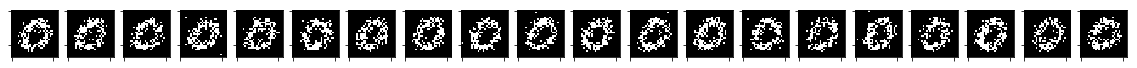

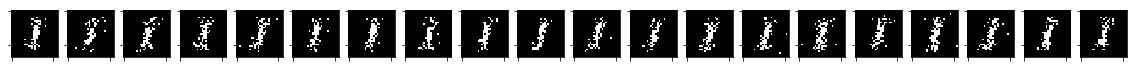

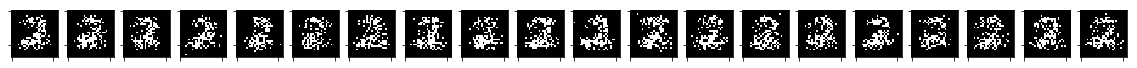

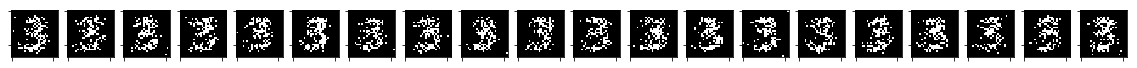

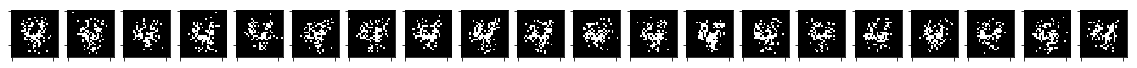

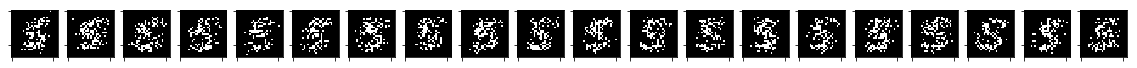

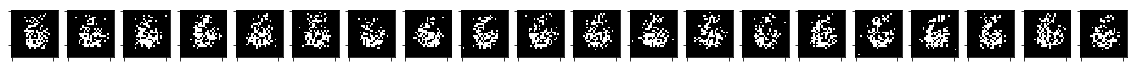

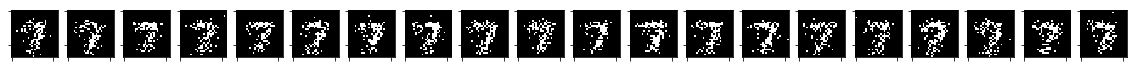

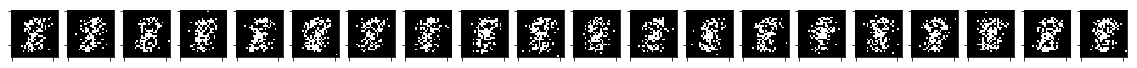

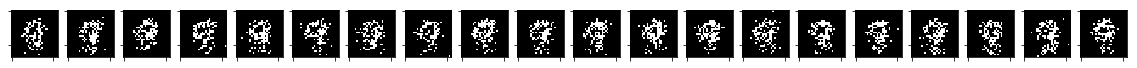

In [23]:
def P10(num_examples):
    default_n = 10000
    n_ex = 20
    
    bnb = BernoulliNB(binarize = 0.5)
    bnb.fit(train_data[:default_n], train_labels[:default_n])
    
    # sample from a binomial distribution with p = exponentiation of the log prob (i.e. the probability)
    examples = [[np.random.binomial(n=1, p=e**n, size = n_ex) for n in a] for a in bnb.feature_log_prob_]
    
    fig_size = 20
    i=0
    for num in examples:
        fig = plt.figure(figsize=(fig_size,fig_size))
        for j in range(n_ex):
            ax = fig.add_subplot(1, n_ex, j + 1)
            image = [examples[j] for examples in num]
            show_image(ax, image)
        i += 1
    plt.show()

P10(20)

ANSWER: Although the examples above hardly resemble the original training digits, it is still, for the most part, possible to recognize the digits with the naked eye. We can see that digits with a lot of features close together and cover a lot of area, like 3 and 8, end up looking more like splotches. This makes it even more clear why we ran in to trouble with these digits in our previous problems.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [24]:
def P11(buckets, correct, total):
    default_n = 10000
    n_ex = 20
    
    bnb = BernoulliNB(alpha = 0.0001)
    train_data_bern = bernoulli_map(train_data)
    bnb.fit(train_data_bern[:default_n], train_labels[:default_n])
    dev_data_bern = bernoulli_map(dev_data)
    dev_labels_pred = bnb.predict(dev_data_bern)
    dev_labels_prob = bnb.predict_proba(dev_data_bern) # returns posterior probability
    dev_zip = list(zip(dev_labels_prob, dev_labels_pred, dev_labels))
    print(dev_labels_pred[0])
    for lbl in dev_zip:
        pr = lbl[0]
        # find index of max posterior
        x_max = max(range(len(pr)), key = lambda x: pr[x])
        p_max = pr[x_max]
        for b in range(len(buckets)):
            if(p_max <= buckets[b]):
                total[b] += 1
                if(lbl[1] == lbl[2]): # correct if lbl_pred = lbl_actual
                    correct[b] += 1
                break
    


buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

8
p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  32    accuracy = 0.375
p(pred) <= 0.9990000000000    total =  94    accuracy = 0.489
p(pred) <= 0.9999900000000    total =  73    accuracy = 0.630
p(pred) <= 0.9999999000000    total =  67    accuracy = 0.806
p(pred) <= 0.9999999990000    total =  73    accuracy = 0.740
p(pred) <= 0.9999999999900    total =  71    accuracy = 0.859
p(pred) <= 0.9999999999999    total =  67    accuracy = 0.866
p(pred) <= 1.0000000000000    total = 523    accuracy = 0.964


ANSWER: The results above indicate that we have a weakly calibrated classifier. There is a positive correlation between the accuracy and the posterior probability, but it is not the case that the posterior probability and accuracy are approximately equivalent.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [25]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()